## XGBoost Model Aquifer Petrignano

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def plot_actual_vs_predicted() -> None:
    i = 0
    for column in y_test.columns:
        # Plot actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.plot(y_test[f'{column}'].values, label=f'Actual {column}')
        plt.plot(y_pred[:, i], label=f'Predicted {column}', linestyle='--')
        plt.legend()
        plt.title(f'Actual vs Predicted - {column}')
        plt.show()
        i+=1

In [2]:
df = pd.read_csv('../../data/clean/Aquifer_Petrignano.csv', index_col='Date', parse_dates=True)
print(df.tail())

            Depth_to_Groundwater_P24  Depth_to_Groundwater_P25
Date                                                          
26/06/2020                    -25.68                    -25.07
27/06/2020                    -25.80                    -25.11
28/06/2020                    -25.80                    -25.19
29/06/2020                    -25.78                    -25.18
30/06/2020                    -25.91                    -25.25


In [3]:
# Creating lag features for the model (for each feature)
def create_lagged_features(data, lag=1):
    df_lagged = data.copy()
    for col in data.columns:
        for i in range(1, lag+1):
            df_lagged[f'{col}_lag{i}'] = df_lagged[col].shift(i)
    return df_lagged.dropna()

# Set the lag (how many past time steps to use)
lag_steps = 5
lagged_data = create_lagged_features(df, lag=lag_steps)

# Input (X) and target (y) data
X = lagged_data.drop(df.columns, axis=1)  # Drop the current values, use lagged features
y = lagged_data[df.columns]  # Predict future values for each feature

# Split into train and test sets (keeping the time series order intact)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

XGBoost model

In [4]:
xgb_model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [5]:
# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred

array([[-26.519424, -26.307894],
       [-26.785046, -26.43946 ],
       [-26.958183, -26.405313],
       ...,
       [-25.764223, -25.075195],
       [-25.903103, -25.180494],
       [-25.903103, -25.18944 ]], dtype=float32)

In [6]:
# Evaluate the model using MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.02318733178072689


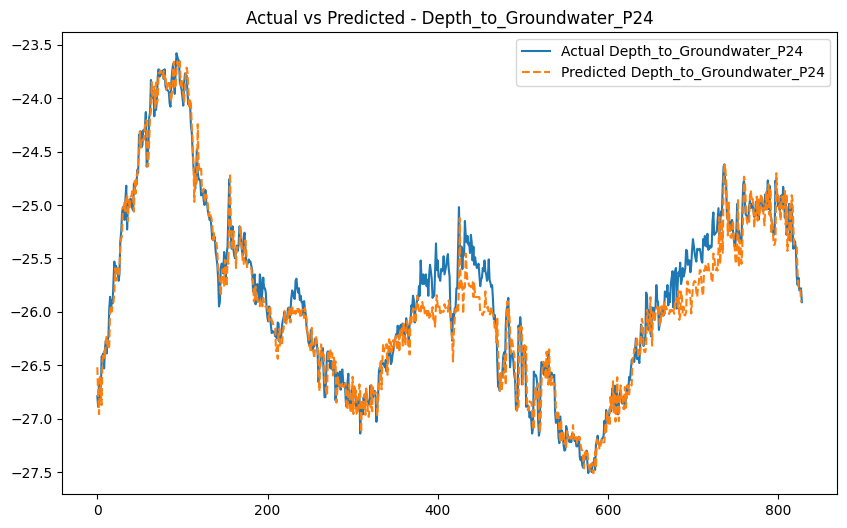

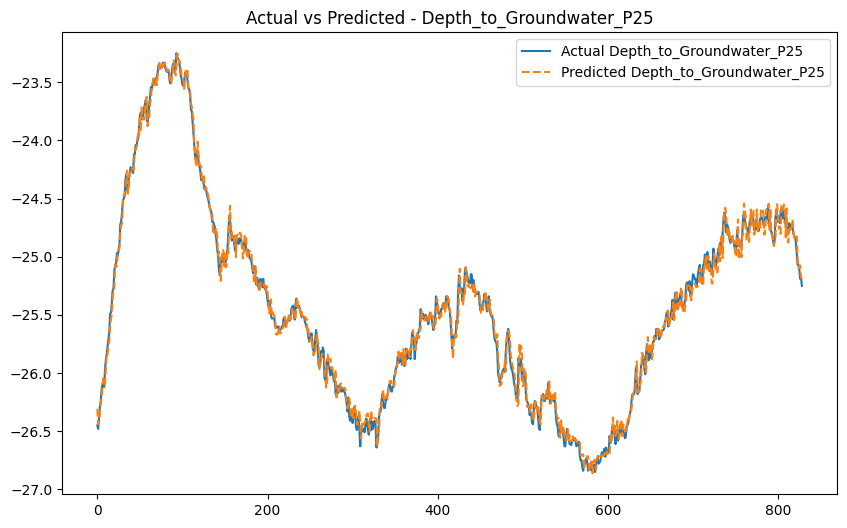

In [7]:
plot_actual_vs_predicted()

Model Optimization

In [8]:
xgb_model = xgb.XGBRegressor()

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],         # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # Step size shrinkage
    'max_depth': [3, 5],                 # Maximum depth of a tree
    'subsample': [0.7, 1.0],           # Fraction of samples used for training each tree
    'colsample_bytree': [0.7, 1.0]     # Fraction of features used per tree
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    verbose=1,  # Set to 1 for output during the search
    n_jobs=-1   # Use all available cores
)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters and model from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


In [9]:
y_pred = best_model.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error of best model: {mse}')

Mean Squared Error of best model: 0.02334791249261821


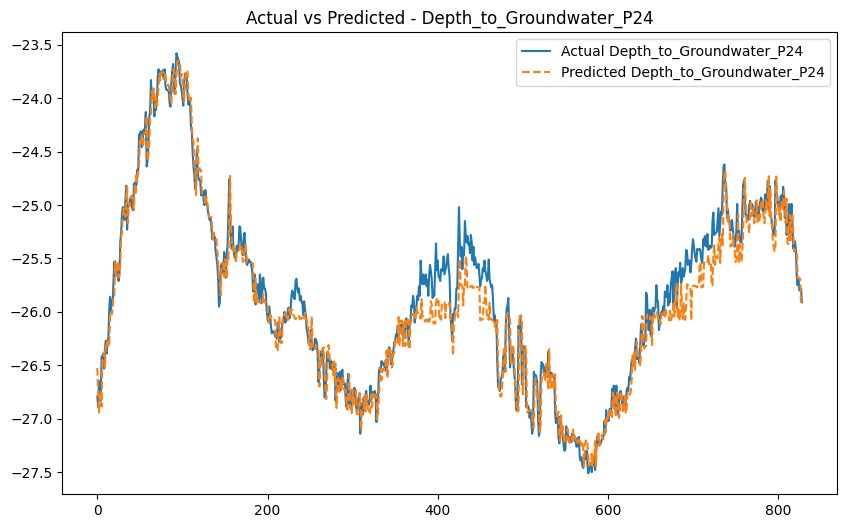

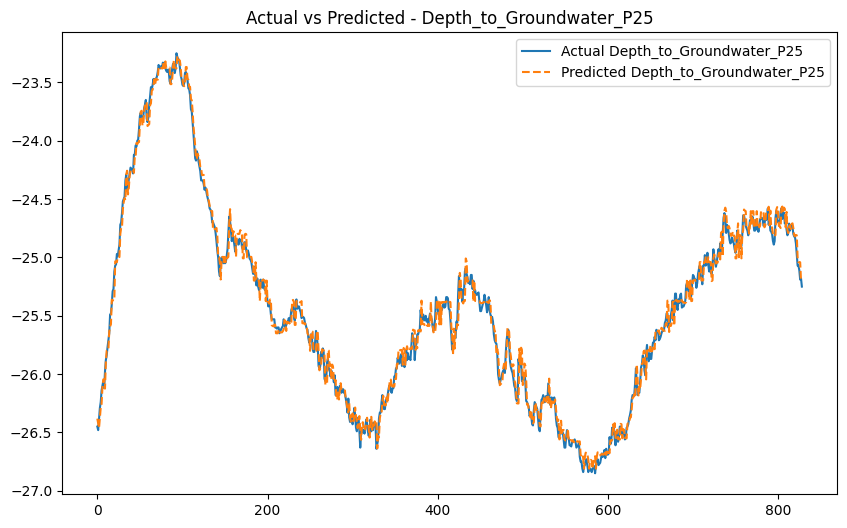

In [10]:
plot_actual_vs_predicted()

In [11]:
import pickle

# Save the model to a file using pickle
with open('../supervised/xgboost_model_Aquifer_Petrignano.pkl', 'wb') as file:
    pickle.dump(best_model, file)